<a href="https://colab.research.google.com/github/coder-gx/my_lcm/blob/main/lcm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# 指定当前的工作文件夹
import os
# 此处为google drive中的文件路径,drive为之前指定的工作根目录，要加上
os.chdir("/content/drive/MyDrive/LCM")


In [ ]:
!pip install --upgrade pip
!pip install --upgrade diffusers transformers accelerate peft


In [ ]:
import torch
from diffusers import LCMScheduler, AutoPipelineForText2Image

model_id = "stabilityai/stable-diffusion-xl-base-1.0"
adapter_id = "latent-consistency/lcm-lora-sdxl"

pipe = AutoPipelineForText2Image.from_pretrained(model_id, torch_dtype=torch.float16, variant="fp16")
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

# load and fuse lcm lora
pipe.load_lora_weights(adapter_id)
pipe.fuse_lora()

prompt = "beautiful girl at seaside, surrounded with flowers, 8k"

# disable guidance_scale by passing 0
image = pipe(prompt=prompt, num_inference_steps=4, guidance_scale=0).images[0]
image.save("/content/drive/MyDrive/LCM/test/test_lcm_lora_sdxl.png")

In [ ]:
import torch
from diffusers import AutoPipelineForImage2Image, LCMScheduler
from diffusers.utils import make_image_grid, load_image

pipe = AutoPipelineForImage2Image.from_pretrained(
    "Lykon/dreamshaper-7",
    torch_dtype=torch.float16,
    variant="fp16",
).to("cuda")

# set scheduler
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)

# load LCM-LoRA
pipe.load_lora_weights("latent-consistency/lcm-lora-sdv1-5")
pipe.fuse_lora()

# prepare image
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/img2img-init.png"
init_image = load_image(url)
prompt = "Astronauts in a jungle, cold color palette, muted colors, detailed, 8k"

# pass prompt and image to pipeline
generator = torch.manual_seed(0)
image = pipe(
    prompt,
    image=init_image,
    num_inference_steps=4,
    guidance_scale=1,
    strength=0.6,
    generator=generator
).images[0]
make_image_grid([init_image, image], rows=1, cols=2)
image.save("/content/drive/MyDrive/LCM/test/test_img2img.png")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
import torch
import cv2
import numpy as np
from PIL import Image

from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, LCMScheduler
from diffusers.utils import load_image

image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
).resize((512, 512))

image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float16,
    safety_checker=None,
    variant="fp16"
).to("cuda")

# set scheduler
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)

# load LCM-LoRA
pipe.load_lora_weights("latent-consistency/lcm-lora-sdv1-5")

generator = torch.manual_seed(0)
image = pipe(
    "the mona lisa",
    image=canny_image,
    num_inference_steps=4,
    guidance_scale=1.5,
    controlnet_conditioning_scale=0.8,
    cross_attention_kwargs={"scale": 1},
    generator=generator,
).images[0]
make_image_grid([canny_image, image], rows=1, cols=2)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/4 [00:00<?, ?it/s]

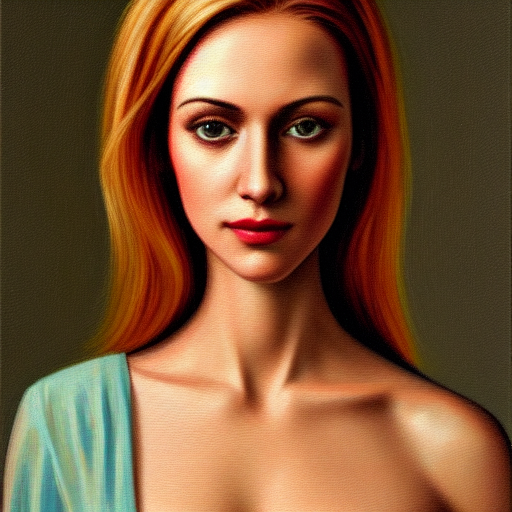

In [ ]:
import torch
from diffusers import LCMScheduler, AutoPipelineForText2Image

model_id = "runwayml/stable-diffusion-v1-5"
adapter_id = "latent-consistency/lcm-lora-sdv1-5"
#adapter_id="XanderGong/my-lcm"
pipe = AutoPipelineForText2Image.from_pretrained(model_id, torch_dtype=torch.float16, variant="fp16")
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

# load and fuse lcm lora
pipe.load_lora_weights(adapter_id)
pipe.fuse_lora()


prompt = "Self-portrait oil painting, a beautiful cyborg with golden hair, 8k"

# disable guidance_scale by passing 0
image = pipe(prompt=prompt, num_inference_steps=4, guidance_scale=0).images[0]
image

In [ ]:
!git clone -b dev https://github.com/camenduru/webui-lcm
!pip install -q diffusers gradio==3.48.0 accelerate transformers
%env PYTHONPATH=/content/webui-lcm
%cd /content/webui-lcm
!python scripts/main.py

Cloning into 'webui-lcm'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 82 (delta 35), reused 39 (delta 14), pack-reused 0
Receiving objects: 100% (82/82), 3.44 MiB | 19.69 MiB/s, done.
Resolving deltas: 100% (35/35), done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 5.1 MB/s eta